In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
import lightgbm as lgb

In [4]:
#set seed
np.random.seed(42)

In [5]:
#Methods for training
def trainMod(params, d_train, itera, d_test):  #Creates and trains a model, returns it. 
    #takes a parameters dictionary, a train dataset, the number of trees/iterations, a validation dataset and the number of rounds ton train if validation error does not improve
    clf = lgb.train(params, d_train, itera, d_test)
    return clf                                 #returns a trained model

In [6]:
def testPred(clf, val_X, val_y):               #Predicts for validation set, and prints error
    y_pred = clf.predict(val_X)
    print("Mean squared is:", np.mean(np.square(val_y-y_pred)))
    return y_pred

In [7]:
def pred(clf, test_X):                         #Predicts for an input set, takes as input model to use and datafram with data
    IDs = test_X["id"]
    test_X = test_X.drop(columns="id")
    pred = clf.predict(test_X)
    return (IDs, pred)

In [8]:
import sys
sys.path.append('..')

In [9]:
#Load data
path = "../data/descriptor/DescriptorData.csv"
data = pd.read_csv(path)
data.columns

Index(['material_id', 'energy', 'energy_per_atom', 'band_gap',
       'total_magnetization', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13'],
      dtype='object')

In [10]:
y = data["energy_per_atom"] #feature to predict
toDrop = ["material_id", "total_magnetization", "energy", "energy_per_atom", "band_gap"] #drop these
X = data.drop(columns=toDrop) #drop unwanted features
X #Show data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,6.5,1.5,1.5,0.5,3.0,2.0,8.800000,0.800000,7.20000,-4.800000,4.413094,-1.060947,3.352150,0.000002
1,17.5,3.5,-9.5,-3.5,1.5,0.5,3.500000,-2.500000,3.00000,1.000000,8.805744,-4.097701,6.857758,4.503737
2,15.5,5.5,-5.5,-5.5,5.0,1.0,4.333333,2.333333,5.00000,-1.000000,3.188573,0.141018,2.782234,0.020056
3,13.0,1.0,-5.0,-1.0,2.0,-1.0,7.000000,-1.000000,8.00000,4.000000,3.074499,0.527501,2.546999,-0.000000
4,12.0,3.0,-3.0,-2.0,4.0,2.0,7.000000,1.000000,8.00000,-4.000000,3.246873,-0.584746,2.691912,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18957,20.0,1.0,-13.0,2.0,10.0,-6.0,2.375000,-0.375000,2.50000,0.500000,3.380378,0.891985,2.384921,-0.510342
18958,14.5,5.5,-4.5,-7.5,9.0,3.0,4.000000,-0.000000,3.00000,-1.000000,5.153850,-0.563046,2.996383,-0.005741
18959,15.0,5.0,-4.0,-8.0,1.0,0.0,6.000000,0.000000,8.00000,0.000000,3.600000,0.000000,3.117691,0.000000
18960,18.5,0.5,-13.5,-1.5,6.0,4.0,4.200000,-1.800000,5.40000,0.400000,3.324509,-1.130982,2.717591,1.195841


In [11]:
#inspect the value to predict
y.describe()

count    18962.000000
mean        -5.306329
std          2.396340
min        -13.701623
25%         -7.084322
50%         -5.076996
75%         -3.473633
max         -0.406819
Name: energy_per_atom, dtype: float64

In [12]:
#Split inmto train and test set, with test fraction 20%
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 42, test_size=0.2) 
val_X, hold_X, val_y, hold_y = train_test_split(val_X, val_y, random_state = 42, test_size=0.1) #holdout set not used for training

In [13]:
d_train = lgb.Dataset(train_X, train_y) #create lgb datasets for faster processing
d_val= lgb.Dataset(val_X, val_y)

In [14]:
# training parameters, saved in a dict
itera = 2500

In [15]:
params = {
    'learning_rate' : 3e-2, #learning rate
    'data_random_seed' : 42,
    'boosting_type' : 'gbdt', #gradient boosted trees method
    'objective' : 'regression',
    'metric' : ['mse'], #error metric, error function to minimize
    'feature_fraction_seed' : 42,
    'num_leaves': 100, #number of leaves in each tree, decreases bias but may overfit
    'min_data' : 50, #minimum data in each leaf, reduces overfitting
    'max_depth' : 10, #maximum depth of each tree, -1 means no limit
    'num_threads' : 4, #number of threads to use for training
    'verbosity' : 1,
    'bagging_fraction' : 0.85, # randomly bag or subsample training data. Reduces overfitting
    'bagging_freq' : 1, # perform bagging every Kth iteration, disabled if 0.
    'bagging_seed' : 42,
    'feature_fraction' : 0.75
}

In [16]:
#CV, 5 folds
metrics = lgb.cv(params, d_train, num_boost_round=itera, verbose_eval=100, stratified=False)

[100]	cv_agg's l2: 0.958448 + 0.0316276
[200]	cv_agg's l2: 0.806455 + 0.031679
[300]	cv_agg's l2: 0.768101 + 0.0335862
[400]	cv_agg's l2: 0.746054 + 0.0327655
[500]	cv_agg's l2: 0.73115 + 0.0325214
[600]	cv_agg's l2: 0.720496 + 0.0314202
[700]	cv_agg's l2: 0.714462 + 0.0308802
[800]	cv_agg's l2: 0.709577 + 0.0308066
[900]	cv_agg's l2: 0.706556 + 0.0311315
[1000]	cv_agg's l2: 0.703417 + 0.0311337
[1100]	cv_agg's l2: 0.701294 + 0.0303954
[1200]	cv_agg's l2: 0.700075 + 0.0308791
[1300]	cv_agg's l2: 0.700265 + 0.0300165
[1400]	cv_agg's l2: 0.70046 + 0.0302631
[1500]	cv_agg's l2: 0.700649 + 0.0297973
[1600]	cv_agg's l2: 0.70022 + 0.0301295
[1700]	cv_agg's l2: 0.700891 + 0.03056
[1800]	cv_agg's l2: 0.70182 + 0.0308754
[1900]	cv_agg's l2: 0.702208 + 0.0303784
[2000]	cv_agg's l2: 0.703017 + 0.0307929
[2100]	cv_agg's l2: 0.703567 + 0.0304092
[2200]	cv_agg's l2: 0.704124 + 0.0306615
[2300]	cv_agg's l2: 0.705236 + 0.0307025
[2400]	cv_agg's l2: 0.706392 + 0.0313253
[2500]	cv_agg's l2: 0.707627 + 0

In [17]:
optimal_rounds = np.argmin(metrics["l2-mean"])
best_cv_score = min(metrics["l2-mean"])

In [18]:
print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds, best_cv_score, metrics["l2-mean"][optimal_rounds]))


Optimal Round: 1345
Optimal Score: 0.6997204063131579 + 0.6997204063131579


In [19]:
#train model
model=trainMod(params, d_train, optimal_rounds, d_val)

[1]	valid_0's l2: 5.59297
[2]	valid_0's l2: 5.3623
[3]	valid_0's l2: 5.14939
[4]	valid_0's l2: 4.95343
[5]	valid_0's l2: 4.76624
[6]	valid_0's l2: 4.58795
[7]	valid_0's l2: 4.4425
[8]	valid_0's l2: 4.31658
[9]	valid_0's l2: 4.17152
[10]	valid_0's l2: 4.02123
[11]	valid_0's l2: 3.87081
[12]	valid_0's l2: 3.72847
[13]	valid_0's l2: 3.59926
[14]	valid_0's l2: 3.47183
[15]	valid_0's l2: 3.35815
[16]	valid_0's l2: 3.24562
[17]	valid_0's l2: 3.13698
[18]	valid_0's l2: 3.0647
[19]	valid_0's l2: 2.96423
[20]	valid_0's l2: 2.86791
[21]	valid_0's l2: 2.77918
[22]	valid_0's l2: 2.69626
[23]	valid_0's l2: 2.61769
[24]	valid_0's l2: 2.53408
[25]	valid_0's l2: 2.47644
[26]	valid_0's l2: 2.40967
[27]	valid_0's l2: 2.34592
[28]	valid_0's l2: 2.27746
[29]	valid_0's l2: 2.22001
[30]	valid_0's l2: 2.15813
[31]	valid_0's l2: 2.10597
[32]	valid_0's l2: 2.04746
[33]	valid_0's l2: 1.9944
[34]	valid_0's l2: 1.94899
[35]	valid_0's l2: 1.90677
[36]	valid_0's l2: 1.86454
[37]	valid_0's l2: 1.82435
[38]	valid_0's

[296]	valid_0's l2: 0.684977
[297]	valid_0's l2: 0.684869
[298]	valid_0's l2: 0.684766
[299]	valid_0's l2: 0.684655
[300]	valid_0's l2: 0.684468
[301]	valid_0's l2: 0.68426
[302]	valid_0's l2: 0.684095
[303]	valid_0's l2: 0.683766
[304]	valid_0's l2: 0.683483
[305]	valid_0's l2: 0.682546
[306]	valid_0's l2: 0.682175
[307]	valid_0's l2: 0.681797
[308]	valid_0's l2: 0.681569
[309]	valid_0's l2: 0.681241
[310]	valid_0's l2: 0.681089
[311]	valid_0's l2: 0.680931
[312]	valid_0's l2: 0.67996
[313]	valid_0's l2: 0.679541
[314]	valid_0's l2: 0.679566
[315]	valid_0's l2: 0.679282
[316]	valid_0's l2: 0.678646
[317]	valid_0's l2: 0.678119
[318]	valid_0's l2: 0.677895
[319]	valid_0's l2: 0.677692
[320]	valid_0's l2: 0.677418
[321]	valid_0's l2: 0.6766
[322]	valid_0's l2: 0.676477
[323]	valid_0's l2: 0.676307
[324]	valid_0's l2: 0.675597
[325]	valid_0's l2: 0.675149
[326]	valid_0's l2: 0.674246
[327]	valid_0's l2: 0.673994
[328]	valid_0's l2: 0.673843
[329]	valid_0's l2: 0.67352
[330]	valid_0's l2:

[587]	valid_0's l2: 0.62962
[588]	valid_0's l2: 0.629641
[589]	valid_0's l2: 0.629653
[590]	valid_0's l2: 0.629583
[591]	valid_0's l2: 0.629451
[592]	valid_0's l2: 0.629522
[593]	valid_0's l2: 0.629125
[594]	valid_0's l2: 0.629217
[595]	valid_0's l2: 0.628932
[596]	valid_0's l2: 0.628865
[597]	valid_0's l2: 0.628936
[598]	valid_0's l2: 0.628913
[599]	valid_0's l2: 0.628889
[600]	valid_0's l2: 0.628888
[601]	valid_0's l2: 0.628831
[602]	valid_0's l2: 0.628797
[603]	valid_0's l2: 0.628676
[604]	valid_0's l2: 0.628702
[605]	valid_0's l2: 0.628646
[606]	valid_0's l2: 0.628243
[607]	valid_0's l2: 0.62821
[608]	valid_0's l2: 0.627985
[609]	valid_0's l2: 0.628102
[610]	valid_0's l2: 0.628064
[611]	valid_0's l2: 0.628019
[612]	valid_0's l2: 0.627953
[613]	valid_0's l2: 0.627778
[614]	valid_0's l2: 0.627732
[615]	valid_0's l2: 0.627533
[616]	valid_0's l2: 0.627557
[617]	valid_0's l2: 0.627393
[618]	valid_0's l2: 0.627284
[619]	valid_0's l2: 0.627248
[620]	valid_0's l2: 0.627319
[621]	valid_0's 

[886]	valid_0's l2: 0.602891
[887]	valid_0's l2: 0.602984
[888]	valid_0's l2: 0.60299
[889]	valid_0's l2: 0.602815
[890]	valid_0's l2: 0.602826
[891]	valid_0's l2: 0.602818
[892]	valid_0's l2: 0.602842
[893]	valid_0's l2: 0.602723
[894]	valid_0's l2: 0.602682
[895]	valid_0's l2: 0.602611
[896]	valid_0's l2: 0.60242
[897]	valid_0's l2: 0.602409
[898]	valid_0's l2: 0.60229
[899]	valid_0's l2: 0.60231
[900]	valid_0's l2: 0.60211
[901]	valid_0's l2: 0.602162
[902]	valid_0's l2: 0.602081
[903]	valid_0's l2: 0.601993
[904]	valid_0's l2: 0.601829
[905]	valid_0's l2: 0.601629
[906]	valid_0's l2: 0.601622
[907]	valid_0's l2: 0.601619
[908]	valid_0's l2: 0.601728
[909]	valid_0's l2: 0.601716
[910]	valid_0's l2: 0.601521
[911]	valid_0's l2: 0.601594
[912]	valid_0's l2: 0.601574
[913]	valid_0's l2: 0.6016
[914]	valid_0's l2: 0.601564
[915]	valid_0's l2: 0.601605
[916]	valid_0's l2: 0.601568
[917]	valid_0's l2: 0.601635
[918]	valid_0's l2: 0.601784
[919]	valid_0's l2: 0.601737
[920]	valid_0's l2: 0

[1173]	valid_0's l2: 0.59601
[1174]	valid_0's l2: 0.596056
[1175]	valid_0's l2: 0.596073
[1176]	valid_0's l2: 0.596049
[1177]	valid_0's l2: 0.596062
[1178]	valid_0's l2: 0.596053
[1179]	valid_0's l2: 0.596143
[1180]	valid_0's l2: 0.596189
[1181]	valid_0's l2: 0.596179
[1182]	valid_0's l2: 0.596191
[1183]	valid_0's l2: 0.595957
[1184]	valid_0's l2: 0.595961
[1185]	valid_0's l2: 0.595656
[1186]	valid_0's l2: 0.595593
[1187]	valid_0's l2: 0.595702
[1188]	valid_0's l2: 0.595767
[1189]	valid_0's l2: 0.595615
[1190]	valid_0's l2: 0.595526
[1191]	valid_0's l2: 0.595579
[1192]	valid_0's l2: 0.595575
[1193]	valid_0's l2: 0.595683
[1194]	valid_0's l2: 0.595628
[1195]	valid_0's l2: 0.595724
[1196]	valid_0's l2: 0.595878
[1197]	valid_0's l2: 0.595757
[1198]	valid_0's l2: 0.595717
[1199]	valid_0's l2: 0.595697
[1200]	valid_0's l2: 0.595678
[1201]	valid_0's l2: 0.595451
[1202]	valid_0's l2: 0.595512
[1203]	valid_0's l2: 0.595412
[1204]	valid_0's l2: 0.595323
[1205]	valid_0's l2: 0.595326
[1206]	vali

In [20]:
#predict on validation set, print error
predicted = testPred(model, hold_X, hold_y)

Mean squared is: 0.6946155587808737


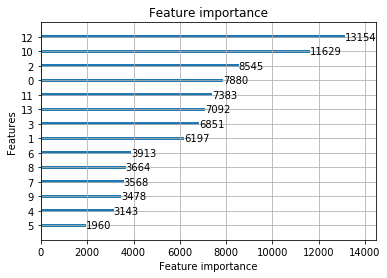

In [21]:
#plot feature importances based on maximum improvement of splits
lgb.plot_importance(model)

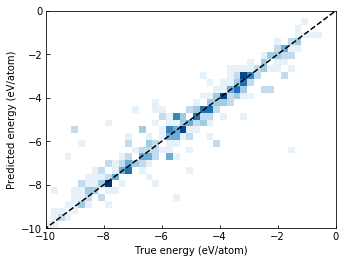

In [22]:
import matplotlib.colors
from matplotlib import cm

colors=cm.get_cmap('Blues', 12)(np.linspace(0,1,16))
colors[0]=np.array([1.,1.,1.,1.])

newmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

plt.plot(np.arange(-14,0+1,1),np.arange(-14,0+1,1),'--',c='black')
plt.hist2d(hold_y, predicted, bins=[60,45],range=[[-14,0],[-14,0]],cmap=newmap) #plt.cm.Blues

plt.margins(x=0)
plt.xlabel('True energy (eV/atom)')
plt.ylabel('Predicted energy (eV/atom)')

plt.rc('xtick',labelsize=14)
plt.rc('axes',labelsize=16)
plt.rc('ytick',labelsize=14)
plt.tick_params(direction='in')

plt.gca().set_xlim([-10,0])
plt.gca().set_ylim([-10,0])
plt.xticks(np.arange(-10,0+2,2))
plt.gca().set_aspect(0.75)
        
#plt.show()
plt.savefig('Accuracy.pdf',dpi=300,bbox_inches='tight')